# Convolutional Neural Networks

- https://d2l.ai/chapter_convolutional-neural-networks/index.html
- https://github.com/fastai/course22p2/blob/master/nbs/07_convolutions.ipynb
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

An MLP is one of appropriate options when we are dealing with tabular data. By tabular, we mean that the data consist of rows corresponding to examples and columns corresponding to features. With tabular data, we might anticipate that the patterns we seek could involve interactions among the features, but we do not assume any structure a priori concerning how the features interact.

Sometimes, we truly lack the knowledge to be able to guide the construction of fancier architectures. In these cases, an MLP may be the best that we can do. However, for high-dimensional perceptual data, such structureless networks can grow unwieldy.

For instance, let's consider an example of distinguishing cats from dogs. Say that we do a thorough job in data collection, collecting an annotated dataset of one-megapixel photographs. This means that each input to the network has one million dimensions. Even an aggressive reduction to one thousand hidden dimensions would require a fully connected layer characterized by $10^6 \times 10^3 = 10^9$ parameters. Unless we have lots of GPUs, a talent for distributed optimization, and an extraordinary amount of patience, learning the parameters of this network may turn out to be infeasible.

Images exhibit rich structure that can be exploited by humans and machine learning models alike. **Convolutional neural networks (CNNs)** are one creative way that machine learning has embraced for exploiting some of the known structure in natural images.

## Invariance

Imagine that we want to detect an object in an image. It seems reasonable that whatever method we use to recognize objects should not be overly concerned with the precise location of the object in the image. We could sweep the image with an object detector that could assign a score to each patch, indicating the likelihood that the patch contains the object we find.

CNNs systematize this idea of **spatial invariance**, exploiting it to learn useful representations with fewer parameters.

We can now make these intuitions more concrete by enumerating a few desiderata to guide our design of a neural network architecture suitable for computer vision:
1. In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image. This principle is called **translation invariance**.
1. The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions. This is the **locality principle**. Eventually, these local representations can be aggregated to make predictions at the whole image level.
1. As we proceed, deeper layers should be able to capture longer-range features of the image, in a way similar to higher level vision in nature.

## Constraining the MLP

To start off, we can consider an MLP
with two-dimensional images $\mathbf{X}$ as inputs
and their immediate hidden representations
$\mathbf{H}$ similarly represented as matrices, where both $\mathbf{X}$ and $\mathbf{H}$ have the same shape. We now imagine that not only the inputs but
also the hidden representations possess spatial structure.

Let $[\mathbf{X}]_{i, j}$ and $[\mathbf{H}]_{i, j}$ denote the pixel
at location $(i,j)$
in the input image and hidden representation, respectively.
We could formally express the fully connected layer as

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

The switch from $\mathsf{W}$ to $\mathsf{V}$ is entirely cosmetic for now
since there is a one-to-one correspondence
between coefficients in both fourth-order tensors.
We simply re-index the subscripts $(k, l)$
such that $k = i+a$ and $l = j+b$.
In other words, we set $[\mathsf{V}]_{i, j, a, b} = [\mathsf{W}]_{i, j, i+a, j+b}$.
The indices $a$ and $b$ run over both positive and negative offsets,
covering the entire image.
For any given location ($i$, $j$) in the hidden representation $[\mathbf{H}]_{i, j}$,
we compute its value by summing over pixels in $x$,
centered around $(i, j)$ and weighted by $[\mathsf{V}]_{i, j, a, b}$. Before we carry on, let's consider the total number of parameters required for a *single* layer in this parametrization: a $1000 \times 1000$ image (1 megapixel) is mapped to a $1000 \times 1000$ hidden representation. This requires $10^{12}$ parameters, far beyond what computers currently can handle.  

### Translation Invariance

Now let's invoke the first principle
established above: translation invariance.
This implies that a shift in the input $\mathbf{X}$
should simply lead to a shift in the hidden representation $\mathbf{H}$.
This is only possible if $\mathsf{V}$ and $\mathbf{U}$ do not actually depend on $(i, j)$. As such,
we have $[\mathsf{V}]_{i, j, a, b} = [\mathbf{V}]_{a, b}$ and $\mathbf{U}$ is a constant, say $u$.
As a result, we can simplify the definition for $\mathbf{H}$:

$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$


This is a *convolution* (actually cross-correlation)!
We are effectively weighting pixels at $(i+a, j+b)$
in the vicinity of location $(i, j)$ with coefficients $[\mathbf{V}]_{a, b}$
to obtain the value $[\mathbf{H}]_{i, j}$.
Note that $[\mathbf{V}]_{a, b}$ needs many fewer coefficients than $[\mathsf{V}]_{i, j, a, b}$ since it
no longer depends on the location within the image. Consequently, the number of parameters required is no longer $10^{12}$ but a much more reasonable $4 \times 10^6$: we still have the dependency on $a, b \in (-1000, 1000)$.

###  Locality

Now let's invoke the second principle: locality.
As motivated above, we believe that we should not have
to look very far away from location $(i, j)$
in order to glean relevant information
to assess what is going on at $[\mathbf{H}]_{i, j}$.
This means that outside some range $|a|> \Delta$ or $|b| > \Delta$,
we should set $[\mathbf{V}]_{a, b} = 0$.
Equivalently, we can rewrite $[\mathbf{H}]_{i, j}$ as

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

This reduces the number of parameters from $4 \times 10^6$ to $4 \Delta^2$, where $\Delta$ is typically smaller than $10$. As such, we reduced the number of parameters by another four orders of magnitude. Note that this is called a *convolutional layer*.
**Convolutional neural networks** (CNNs)
are a special family of neural networks that contain convolutional layers.
In the deep learning research community,
$\mathbf{V}$ is referred to as a *convolution kernel*,
a *filter*, or simply the layer's *weights* that are learnable parameters.

While previously, we might have required billions of parameters
to represent just a single layer in an image-processing network,
we now typically need just a few hundred, without
altering the dimensionality of either
the inputs or the hidden representations.
The price paid for this drastic reduction in parameters
is that our features are now translation invariant
and that our layer can only incorporate local information,
when determining the value of each hidden activation.
All learning depends on imposing **inductive bias**.
When that bias agrees with reality,
we get sample-efficient models
that generalize well to unseen data.
But of course, if those biases do not agree with reality,
e.g., if images turned out not to be translation invariant,
our models might struggle even to fit our training data.

This dramatic reduction in parameters brings us to our last desideratum,
namely that deeper layers should represent larger and more complex aspects
of an image. This can be achieved by interleaving nonlinearities and convolutional
layers repeatedly.


## Convolutions

Let's briefly review why the equation is called a convolution.
In mathematics, the *convolution* between two functions,
say $f, g: \mathbb{R}^d \to \mathbb{R}$ is defined as

$$(f * g)(\mathbf{x}) = \int f(\mathbf{z}) g(\mathbf{x}-\mathbf{z}) d\mathbf{z}.$$

That is, we measure the overlap between $f$ and $g$
when one function is "flipped" and shifted by $\mathbf{x}$.
Whenever we have discrete objects, the integral turns into a sum.
For instance, for vectors from
the set of square-summable infinite-dimensional vectors
with index running over $\mathbb{Z}$ we obtain the following definition:

$$(f * g)(i) = \sum_a f(a) g(i-a).$$

For two-dimensional tensors, we have a corresponding sum
with indices $(a, b)$ for $f$ and $(i-a, j-b)$ for $g$, respectively:

$$(f * g)(i, j) = \sum_a\sum_b f(a, b) g(i-a, j-b).$$

This looks similar to the convolutional layer equation, with one major difference.
Rather than using $(i+a, j+b)$, we are using the difference instead.
Note, though, that this distinction is mostly cosmetic
since we can always match the notation between them.
Our original definition of the convolutional layer more properly describes a *cross-correlation*.


## Channels
So far, we blissfully ignored that images consist
of three channels: red, green, and blue.
In sum, images are not two-dimensional objects
but rather third-order tensors,
characterized by a height, width, and channel,
e.g., with shape $1024 \times 1024 \times 3$ pixels.
While the first two of these axes concern spatial relationships,
the third can be regarded as assigning
a multidimensional representation to each pixel location.
We thus index $\mathsf{X}$ as $[\mathsf{X}]_{i, j, k}$.
The convolutional filter has to adapt accordingly.
Instead of $[\mathbf{V}]_{a,b}$, we now have $[\mathsf{V}]_{a,b,c}$.

Moreover, just as our input consists of a third-order tensor,
it turns out to be a good idea to similarly formulate
our hidden representations as third-order tensors $\mathsf{H}$.
In other words, rather than just having a single hidden representation
corresponding to each spatial location,
we want an entire vector of hidden representations
corresponding to each spatial location.
We could think of the hidden representations as comprising
a number of two-dimensional grids stacked on top of each other.
As in the inputs, these are sometimes called *channels*.
They are also sometimes called *feature maps*,
as each provides a spatialized set
of learned features for the subsequent layer.
Intuitively, you might imagine that at lower layers that are closer to inputs,
some channels could become specialized to recognize edges while
others could recognize textures.

To support multiple channels in both inputs ($\mathsf{X}$) and hidden representations ($\mathsf{H}$),
we can add a fourth coordinate to $\mathsf{V}$: $[\mathsf{V}]_{a, b, c, d}$.
Putting everything together we have:

$$[\mathsf{H}]_{i,j,d} = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c},$$

where $d$ indexes the output channels in the hidden representations $\mathsf{H}$. The subsequent convolutional layer will go on to take a third-order tensor, $\mathsf{H}$, as input.
This is the definition of a convolutional layer for multiple channels, where $\mathsf{V}$ is a kernel or filter of the layer.

### Multiple Input Channels
When the input data contains multiple channels,
we need to construct a convolution kernel
with the same number of input channels as the input data,
so that it can perform cross-correlation with the input data.
Assuming that the number of channels for the input data is $c_\textrm{i}$,
the number of input channels of the convolution kernel also needs to be $c_\textrm{i}$. If our convolution kernel's window shape is $k_\textrm{h}\times k_\textrm{w}$,
then, when $c_\textrm{i}=1$, we can think of our convolution kernel
as just a two-dimensional tensor of shape $k_\textrm{h}\times k_\textrm{w}$.

However, when $c_\textrm{i}>1$, we need a kernel
that contains a tensor of shape $k_\textrm{h}\times k_\textrm{w}$ for *every* input channel. Concatenating these $c_\textrm{i}$ tensors together
yields a convolution kernel of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
Since the input and convolution kernel each have $c_\textrm{i}$ channels,
we can perform a cross-correlation operation
on the two-dimensional tensor of the input
and the two-dimensional tensor of the convolution kernel
for each channel, adding the $c_\textrm{i}$ results together
(summing over the channels)
to yield a two-dimensional tensor.
This is the result of a two-dimensional cross-correlation
between a multi-channel input and
a multi-input-channel convolution kernel.

![](https://d2l.ai/_images/conv-multi-in.svg)

The above figure provides an example
of a two-dimensional cross-correlation with two input channels.
The shaded portions are the first output element
as well as the input and kernel tensor elements used for the output computation:
$(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

### Multiple Output Channels

Regardless of the number of input channels,
so far we always ended up with one output channel.
However,
it turns out to be essential to have multiple channels at each layer.
In the most popular neural network architectures,
we actually increase the channel dimension
as we go deeper in the neural network,
typically downsampling to trade off spatial resolution
for greater *channel depth*.
Intuitively, you could think of each channel
as responding to a different set of features.

Denote by $c_\textrm{i}$ and $c_\textrm{o}$ the number
of input and output channels, respectively,
and by $k_\textrm{h}$ and $k_\textrm{w}$ the height and width of the kernel.
To get an output with multiple channels,
we can create a kernel tensor
of shape $c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$
for *every* output channel.
We concatenate them on the output channel dimension,
so that the shape of the convolution kernel
is $c_\textrm{o}\times c_\textrm{i}\times k_\textrm{h}\times k_\textrm{w}$.
In cross-correlation operations,
the result on each output channel is calculated
from the convolution kernel corresponding to that output channel
and takes input from all channels in the input tensor.

## $1\times 1$ Convolutional Layer
At first, a **$1 \times 1$ convolution**, i.e., $k_\textrm{h} = k_\textrm{w} = 1$,
does not seem to make much sense.
After all, a convolution correlates adjacent pixels.
A $1 \times 1$ convolution obviously does not.
Nonetheless, they are popular operations that are sometimes included
in the designs of complex deep networks.

Because the minimum window is used,
the $1\times 1$ convolution loses the ability
of larger convolutional layers
to recognize patterns consisting of interactions
among adjacent elements in the height and width dimensions.
The only computation of the $1\times 1$ convolution occurs
on the channel dimension.

![](https://d2l.ai/_images/conv-1x1.svg)

The above figure shows the cross-correlation computation
using the $1\times 1$ convolution kernel
with 3 input channels and 2 output channels.
Note that the inputs and outputs have the same height and width.
Each element in the output is derived
from a linear combination of elements *at the same position*
in the input image.
You could think of the $1\times 1$ convolutional layer
as constituting a fully connected layer applied at every single pixel location
to transform the $c_\textrm{i}$ corresponding input values into $c_\textrm{o}$ output values.
Because this is still a convolutional layer,
the weights are tied across pixel location.
Thus the $1\times 1$ convolutional layer requires $c_\textrm{o}\times c_\textrm{i}$ weights
(plus the bias). Also note that convolutional layers are typically followed
by nonlinearities. This ensures that $1 \times 1$ convolutions cannot simply be
folded into other convolutions.

## The Cross-Correlation Operation

Strictly speaking, convolutional layers
are a  misnomer, since the operations they express
are more accurately described as cross-correlations.
Based on our descriptions of convolutional layers,
in such a layer, an input tensor
and a kernel tensor are combined
to produce an output tensor through a **cross-correlation operation.**

Let's ignore channels for now and see how this works
with two-dimensional data and hidden representations.

![](http://d2l.ai/_images/correlation.svg)

The input is a two-dimensional tensor
with a height of 3 and width of 3.
We mark the shape of the tensor as $3 \times 3$ or ($3$, $3$).
The height and width of the kernel are both 2.
The shape of the *kernel window* (or *convolution window*)
is given by the height and width of the kernel
(here it is $2 \times 2$).

In the two-dimensional cross-correlation operation,
we begin with the convolution window positioned
at the upper-left corner of the input tensor
and slide it across the input tensor,
both from left to right and top to bottom.
When the convolution window slides to a certain position,
the input subtensor contained in that window
and the kernel tensor are multiplied elementwise
and the resulting tensor is summed up
yielding a single scalar value.
This result gives the value of the output tensor
at the corresponding location.
Here, the output tensor has a height of 2 and width of 2
and the four elements are derived from
the two-dimensional cross-correlation operation:

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Note that along each axis, the output size
is slightly smaller than the input size.
Because the kernel has width and height greater than $1$,
we can only properly compute the cross-correlation
for locations where the kernel fits wholly within the image,
the output size is given by the input size $n_\textrm{h} \times n_\textrm{w}$
minus the size of the convolution kernel $k_\textrm{h} \times k_\textrm{w}$
via

$$(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1).$$

This is the case since we need enough space
to "shift" the convolution kernel across the image.

## Convolutional Layers

A convolutional layer cross-correlates the input and kernel
and adds a scalar bias to produce an output.
The two parameters of a convolutional layer
are the kernel and the scalar bias.
When training models based on convolutional layers,
we typically initialize the kernels randomly,
just as we would with a fully connected layer.

In
$h \times w$ convolution
or an $h \times w$ convolution kernel,
the height and width of the convolution kernel are $h$ and $w$, respectively.
We also refer to
a convolutional layer with an $h \times w$
convolution kernel simply as an $h \times w$ convolutional layer.

## Cross-Correlation and Convolution

Consider two-dimensional convolutional layers.
What if such layers
perform strict convolution operations instead of cross-correlations?
In order to obtain the output of the strict *convolution* operation, we only need to flip the two-dimensional kernel tensor both horizontally and vertically, and then perform the *cross-correlation* operation with the input tensor.

It is noteworthy that since kernels are learned from data in deep learning,
the outputs of convolutional layers remain unaffected
no matter such layers perform either the strict convolution operations
or the cross-correlation operations.

To illustrate this, suppose that a convolutional layer performs *cross-correlation* and learns the kernel, which is here denoted as the matrix $\mathbf{K}$.
Assuming that other conditions remain unchanged,
when this layer instead performs strict *convolution*,
the learned kernel $\mathbf{K}'$ will be the same as $\mathbf{K}$
after $\mathbf{K}'$ is
flipped both horizontally and vertically.
That is to say,
when the convolutional layer
performs strict *convolution*
for the input
and $\mathbf{K}'$,
the same output will be obtained through the cross-correlation of the input and $\mathbf{K}$.

In keeping with standard terminology in deep learning literature,
we will continue to refer to the cross-correlation operation
as a convolution even though, strictly-speaking, it is slightly different. Furthermore, we use the term element to refer to an entry (or component) of any tensor representing a layer representation or a convolution kernel.

## Feature Map and Receptive Field

The convolutional layer output
is sometimes called a *feature map*,
as it can be regarded as
the learned representations (features)
in the spatial dimensions (e.g., width and height)
to the subsequent layer.
In CNNs,
for any element $x$ of some layer,
its *receptive field* refers to
all the elements (from all the previous layers)
that may affect the calculation of $x$
during the forward propagation.
Note that the receptive field
may be larger than the actual size of the input.

![](https://raw.githubusercontent.com/fastai/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00068.png)

The blue highlighted cells are its precedents—that is, the cells used to calculate its value. These cells are the corresponding 3×3 area of cells from the input layer (on the left), and the cells from the filter (on the right).

![](https://raw.githubusercontent.com/fastai/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00069.png)

In this example, we have just two convolutional layers. We can see that a 7×7 area of cells in the input layer is used to calculate the single green cell in the Conv2 layer. This is the receptive field.

The deeper we are in the network, the larger the receptive field for an activation in that layer.

![](https://d2l.ai/_images/correlation.svg)

Given the $2 \times 2$ convolution kernel,
the receptive field of the shaded output element (of value $19$)
is
the four elements in the shaded portion of the input.
Now let's denote the $2 \times 2$
output as $\mathbf{Y}$
and consider a deeper CNN
with an additional $2 \times 2$ convolutional layer that takes $\mathbf{Y}$
as its input, outputting
a single element $z$.
In this case,
the receptive field of $z$
on $\mathbf{Y}$ includes all the four elements of $\mathbf{Y}$,
while
the receptive field
on the input includes all the nine input elements.
Thus,
when any element in a feature map
needs a larger receptive field
to detect input features over a broader area,
we can build a deeper network.

## Convolutions in practice

The image

![](https://miro.medium.com/v2/resize:fit:150/format:webp/1*7zVtk9Xb3X6aQScJqxCUYw.png)

The filter

![](https://miro.medium.com/v2/resize:fit:102/format:webp/1*aCBPCSInHE6vFaECSAT5oA.png)

Since the filter fits in the image four times, we have four results

![](https://miro.medium.com/v2/resize:fit:106/format:webp/1*I8BERkXPnVjdVCawr7Q23A.png)

Here’s how we applied the filter to each section of the image to yield each result

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*s-TmnXo69mAKbnMoMBnpMg.png)

The equation view

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*-TnNZ4srYItcGXov-dTmmw.png)

In [ ]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
mnist = datasets.MNIST(root='data', download=True, train=False)

In [ ]:
sample = mnist[0]
sample

(<PIL.Image.Image image mode=L size=28x28>, 7)

In [ ]:
sample[0]

In [ ]:
sample[1]

7

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
])

image = transform(sample[0])
print(type(image))
print(image.shape)
image

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([1, 28, 28])


Image([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

image = transform(sample[0])
print(type(image))
print(image.shape)
image

<class 'torchvision.tv_tensors._image.Image'>
torch.Size([1, 28, 28])


Image([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor(),
])

image = transform(sample[0])
print(type(image))
print(image.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


In [ ]:
mnist_v2 = datasets.MNIST(root='data', download=True, train=False, transform=transform)
sample_v2 = mnist_v2[0]
sample_v2

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
image = sample_v2[0]
print(type(image))
print(image.shape)

<class 'torch.Tensor'>
torch.Size([1, 28, 28])


In [ ]:
img = image.squeeze()
img.shape

torch.Size([28, 28])

In [ ]:
import matplotlib.pyplot as plt

plt.imshow

The image data shape:
  - (M, N)
  - (M, N, 3) (RGB, 0-1 float or 0-255 int)
  - (M, N, 4) (RGBA, 0-1 float or 0-255 int)

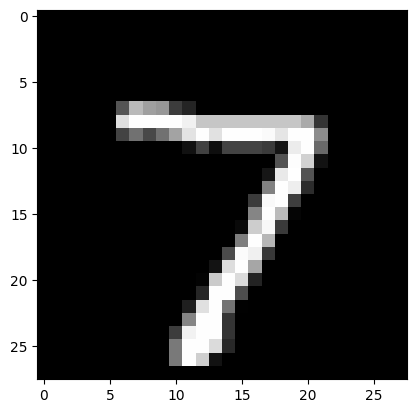

In [ ]:
plt.imshow(img, cmap='gray');

In [ ]:
def apply_kernel(im, row, col, kernel):
  return (im[row-1:row+2, col-1:col+2] * kernel).sum()

In [ ]:
top_edge = torch.FloatTensor(
    [[-1,-1,-1],
     [ 0, 0, 0],
     [ 1, 1, 1]]
)

In [ ]:
rng = range(1,27)
img_top_edge = torch.FloatTensor([[apply_kernel(img, i, j, top_edge) for j in rng] for i in rng])
img_top_edge.shape

torch.Size([26, 26])

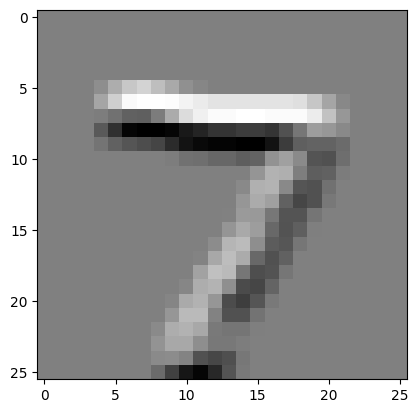

In [ ]:
plt.imshow(img_top_edge, cmap='gray');

In [ ]:
layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
layer.weight.data = top_edge.reshape(1, 1, 3, 3)
layer

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
image_top_edge = layer(image)
image_top_edge.shape

torch.Size([1, 26, 26])

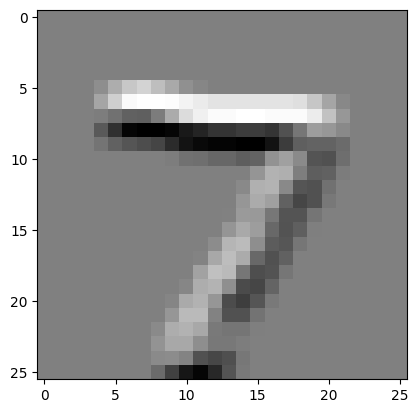

In [ ]:
plt.imshow(image_top_edge.squeeze().detach().numpy(), cmap='gray');

In [ ]:
torch.allclose(image_top_edge, img_top_edge)

True

In [ ]:
layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

In [ ]:
layer.weight

Parameter containing:
tensor([[[[-0.0726, -0.0302, -0.2946],
          [ 0.0949, -0.2066,  0.2154],
          [ 0.0060, -0.2741,  0.0906]]]], requires_grad=True)

In [ ]:
layer.bias

Parameter containing:
tensor([0.1795], requires_grad=True)

## Strides and Padding

With appropriate padding, we can ensure that the output activation map is the same size as the original image.

![](https://raw.githubusercontent.com/fastai/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/chapter9_padconv.svg)

In [ ]:
# (channel, height, width)
x = torch.randn(1, 5, 5)
x.shape

torch.Size([1, 5, 5])

In [ ]:
l = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
l(x).shape

torch.Size([1, 3, 3])

In [ ]:
l = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
l(x).shape

torch.Size([1, 5, 5])

With a 5×5 input, 4×4 kernel, and 2 pixels of padding, we end up with a 6×6 activation map.

![](https://raw.githubusercontent.com/fastai/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00029.png)

In [ ]:
l = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, padding=2)
l(x).shape

torch.Size([1, 6, 6])

We could move over two pixels after each kernel application. This is known as a stride-2 convolution.

![](https://raw.githubusercontent.com/fastai/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/att_00030.png)

In [ ]:
l = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2)
l(x).shape

torch.Size([1, 3, 3])

Assuming that the input shape is $n_\textrm{h}\times n_\textrm{w}$
and the convolution kernel shape is $k_\textrm{h}\times k_\textrm{w}$,
the output shape will be $(n_\textrm{h}-k_\textrm{h}+1) \times (n_\textrm{w}-k_\textrm{w}+1)$:
we can only shift the convolution kernel so far until it runs out
of pixels to apply the convolution to.

In general, if we add a total of $p_\textrm{h}$ rows of padding
(roughly half on top and half on bottom)
and a total of $p_\textrm{w}$ columns of padding
(roughly half on the left and half on the right),
the output shape will be

$$(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+1)\times(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+1).$$

This means that the height and width of the output
will increase by $p_\textrm{h}$ and $p_\textrm{w}$, respectively.

In many cases, we will want to set $p_\textrm{h}=k_\textrm{h}-1$ and $p_\textrm{w}=k_\textrm{w}-1$
to give the input and output the same height and width.

Assuming that $k_\textrm{h}$ is odd here,
we will pad $p_\textrm{h}/2$ rows on both sides of the height.
If $k_\textrm{h}$ is even, one possibility is to
pad $\lceil p_\textrm{h}/2\rceil$ rows on the top of the input
and $\lfloor p_\textrm{h}/2\rfloor$ rows on the bottom.
We will pad both sides of the width in the same way.

CNNs commonly use convolution kernels
with odd height and width values, such as 1, 3, 5, or 7.
Choosing odd kernel sizes has the benefit
that we can preserve the dimensionality
while padding with the same number of rows on top and bottom,
and the same number of columns on left and right.

Moreover, this practice of using odd kernels
and padding to precisely preserve dimensionality
offers a clerical benefit.
For any two-dimensional tensor `X`,
when the kernel's size is odd
and the number of padding rows and columns
on all sides are the same,
thereby producing an output with the same height and width as the input,
we know that the output `Y[i, j]` is calculated
by cross-correlation of the input and convolution kernel
with the window centered on `X[i, j]`.

## Pooling

In many cases our ultimate task asks some global question about the image, e.g., does it contain a cat? Consequently, the units of our final layer should be sensitive to the entire input. By gradually aggregating information, yielding coarser and coarser maps, we accomplish this goal of ultimately learning a global representation, while keeping all of the advantages of convolutional layers at the intermediate layers of processing. The deeper we go in the network, the larger the receptive field (relative to the input) to which each hidden node is sensitive. Reducing spatial resolution accelerates this process, since the convolution kernels cover a larger effective area.

### Maximum Pooling and Average Pooling

Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the pooling window). However, unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer contains no parameters (there is no kernel). Instead, pooling operators are deterministic, typically calculating either the maximum or the average value of the elements in the pooling window. These operations are called maximum pooling (max-pooling for short) and average pooling, respectively.

We can think of the pooling window as starting from the upper-left of the input tensor and sliding across it from left to right and top to bottom. At each location that the pooling window hits, it computes the maximum or average value of the input subtensor in the window, depending on whether max or average pooling is employed.

![](https://d2l.ai/_images/pooling.svg)

- Max-pooling with a pooling window shape of $2 \times 2$. The shaded portions are the first output element as well as the input tensor elements used for the output computation: $\text{max}(0, 1, 3, 4) = 4$.

In [ ]:
X = torch.arange(9, dtype=torch.float32).reshape((1, 3, 3))
X

tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]])

In [ ]:
pool2d = nn.MaxPool2d(2, stride=1)
pool2d(X)

tensor([[[4., 5.],
         [7., 8.]]])

### Padding and Stride

As with convolutional layers, pooling layers
change the output shape.
And as before, we can adjust the operation to achieve a desired output shape
by padding the input and adjusting the stride.
We can demonstrate the use of padding and strides
in pooling layers via the built-in two-dimensional max-pooling layer from the deep learning framework.
We first construct an input tensor `X` whose shape has four dimensions,
where the number of examples (batch size) and number of channels are both 1.

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Since pooling aggregates information from an area, **deep learning frameworks default to matching pooling window sizes and stride.** For instance, if we use a pooling window of shape `(3, 3)`
we get a stride shape of `(3, 3)` by default.

In [ ]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

Needless to say, **the stride and padding can be manually specified** to override framework defaults if required.


In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window with arbitrary height and width respectively, as the example below shows.

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### Multiple Channels

When processing multi-channel input data,
**the pooling layer pools each input channel separately**,
rather than summing the inputs up over channels
as in a convolutional layer.
This means that the number of output channels for the pooling layer
is the same as the number of input channels.
Below, we will concatenate tensors `X` and `X + 1`
on the channel dimension to construct an input with two channels.

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still two after pooling.

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])